In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [101]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler

## 1. Load the dataset

In [75]:
# Load data into pandas dataframe
df = pd.read_csv('/content/drive/MyDrive/final year/ml/data/experimental_dataset.csv')

In [76]:
# separate the lables
labels = df['out_and_tx_malicious']

## 2. Explore the dataset

In [100]:
df.describe()

,in_btc,out_btc,total_btc,mean_in_btc,mean_out_btc,in_malicious,out_malicious,is_malicious,out_and_tx_malicious,all_malicious,vin_sz,vout_sz,size,fee,time,sat_per_byte
count,11325.000000,11325.000000,11325.000000,11325.000000,11325.000000,11325.000000,11325.000000,11325.00000,11325.000000,11325.000000,11325.000000,11325.000000,11325.000000,1.132500e+04,1.132500e+04,11325.000000
mean,97.184900,98.076412,195.261312,73.104483,52.389886,0.107903,0.005740,0.00415,0.009536,0.117086,2.373775,6.750993,637.589934,1.026985e+05,1.356110e+09,181.375239
std,1042.614196,1034.117355,2075.477050,913.477741,547.035130,0.310271,0.075545,0.06429,0.097192,0.321537,10.140495,58.288664,2592.093500,1.264157e+06,2.744573e+07,617.730654
min,0.000000,0.000000,0.000169,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000,1.000000,110.000000,0.000000e+00,1.241439e+09,0.000000
25%,0.090722,0.133266,0.278314,0.056479,0.068375,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000,2.000000,227.000000,1.000000e+04,1.344430e+09,20.725389
50%,1.000000,1.417279,2.941711,0.600000,0.690645,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000,2.000000,258.000000,5.000000e+04,1.362406e+09,114.416476
75%,10.223644,16.389500,32.171700,7.489624,7.803525,0.000000,0.000000,0.00000,0.000000,0.000000,2.000000,2.000000,438.000000,5.000000e+04,1.376548e+09,220.264317
max,48194.908900,48194.908400,96389.817301,48194.908900,24097.454200,1.000000,1.000000,1.00000,1.000000,1.000000,533.000000,2770.000000,96033.000000,9.700000e+07,1.388670e+09,38910.505837


# Normalising the Data
The data have a variety of ranges. To make learning easier, each feature needs to be normalised independently to have roughly the same range.

In [78]:
normalised_data = df.copy()
normalised_data['vin_sz'] = np.log1p(normalised_data['vin_sz'])
normalised_data['vout_sz']= np.log1p(normalised_data['vout_sz'])
normalised_data['in_btc'] = np.log1p(normalised_data['in_btc'])
normalised_data['out_btc']= np.log1p(normalised_data['out_btc'])
normalised_data['total_btc']= np.log1p(normalised_data['total_btc'])
normalised_data['mean_in_btc']= np.log1p(normalised_data['mean_in_btc'])
normalised_data['mean_out_btc']= np.log1p(normalised_data['mean_out_btc'])
normalised_data['size']= np.log1p(normalised_data['size'])
normalised_data['fee']= np.log1p(normalised_data['fee'])
normalised_data['time']= np.log1p(normalised_data['time'])
normalised_data['sat_per_byte']= np.log1p(normalised_data['sat_per_byte'])

In [79]:
normalised_data

,in_btc,out_btc,total_btc,mean_in_btc,mean_out_btc,in_malicious,out_malicious,is_malicious,out_and_tx_malicious,all_malicious,vin_sz,vout_sz,size,fee,time,sat_per_byte
0,3.931826,3.931826,4.615121,3.931826,3.931826,0,0,0,0,0,0.693147,0.693147,5.075174,0.000000,20.968406,0.000000
1,3.931826,3.931826,4.615121,3.931826,3.931826,0,0,0,0,0,0.693147,0.693147,5.416100,0.000000,20.977374,0.000000
2,1.308333,1.308333,1.856298,1.308333,0.854415,0,0,0,0,0,0.693147,1.098612,5.556828,0.000000,20.963552,0.000000
3,0.000000,3.931826,3.931826,0.000000,3.931826,0,0,0,0,0,0.693147,0.693147,4.905275,0.000000,20.958042,0.000000
4,0.000000,3.931826,3.931826,0.000000,3.931826,0,0,0,0,0,0.693147,0.693147,4.905275,0.000000,20.956091,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11320,3.187384,3.187380,3.859673,3.187384,2.534683,1,0,0,0,1,0.693147,1.098612,5.420535,9.210440,21.049497,3.816491
11321,4.189655,4.189503,4.875121,3.511545,3.511396,0,1,0,1,1,1.098612,1.098612,6.086775,13.815512,21.050798,7.731450
11322,7.860571,7.796703,8.522095,7.860571,7.796703,0,1,0,1,1,0.693147,1.098612,5.552960,13.815512,21.050799,8.266691
11323,4.615121,4.615022,5.303255,4.615121,3.931728,0,1,0,1,1,0.693147,1.098612,5.556828,13.815512,21.050798,8.262809


In [86]:
def plot_dist(df):
  count = 0;
  bins = 200
  fig, ax = plt.subplots(2,3, figsize=(16,12))
  for i in range(2):
    for j in range(3):
      ax[i][j].hist(normalised_data.iloc[:,count], bins=bins, alpha=0.9, log=True, density=True)
      ax[i][j].title.set_text(df.columns[count])
      ax[i][j].grid()
      count+=1
plt.show()

In [105]:
df2 = normalised_data[['mean_in_btc', 'mean_out_btc', 'vin_sz', 'vout_sz', 'size', 'sat_per_byte']]

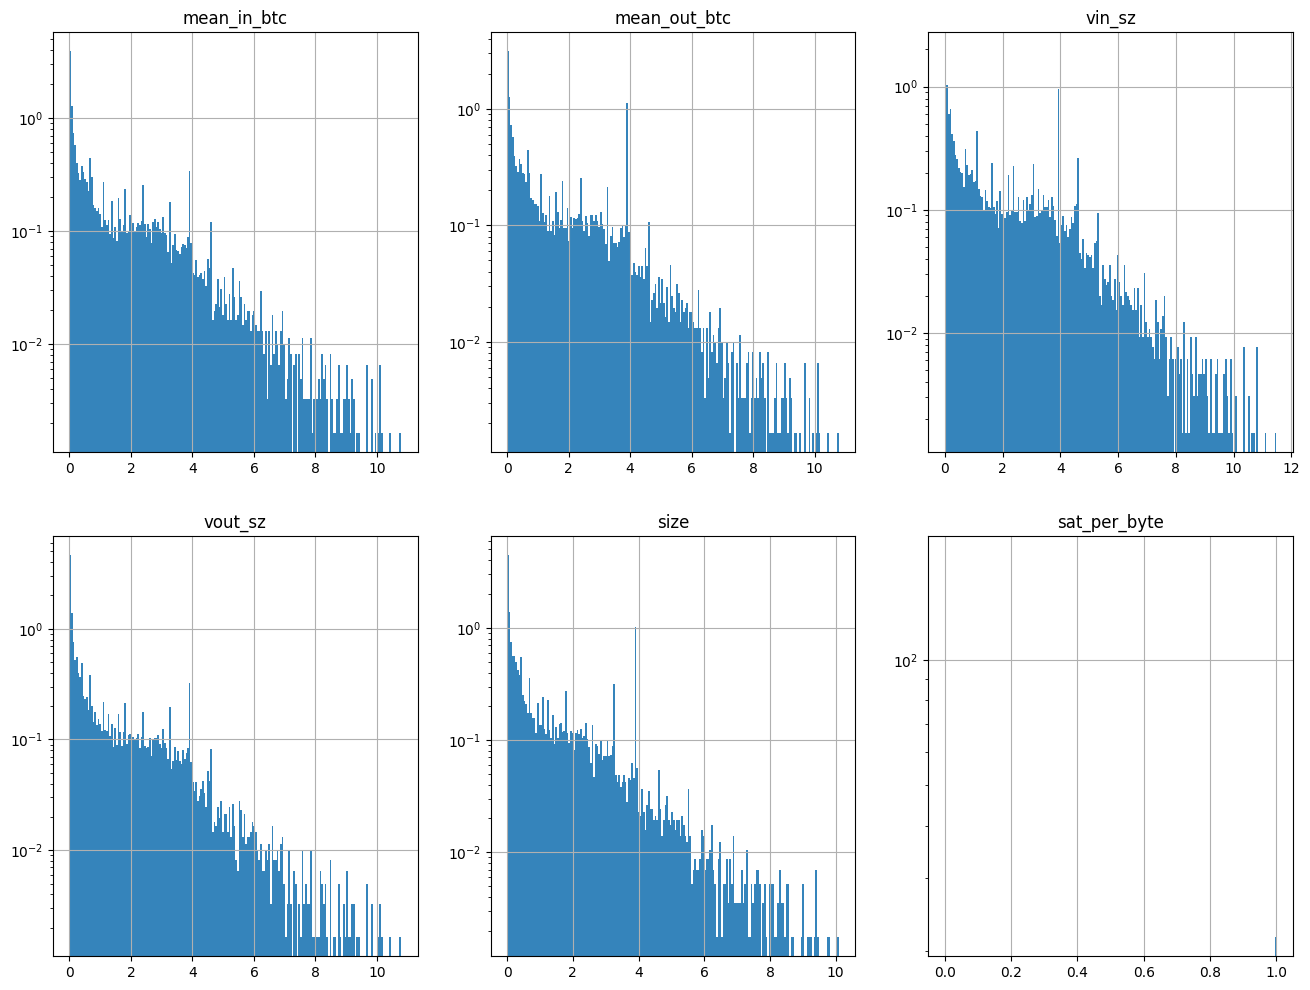

In [106]:
plot_dist(df2)

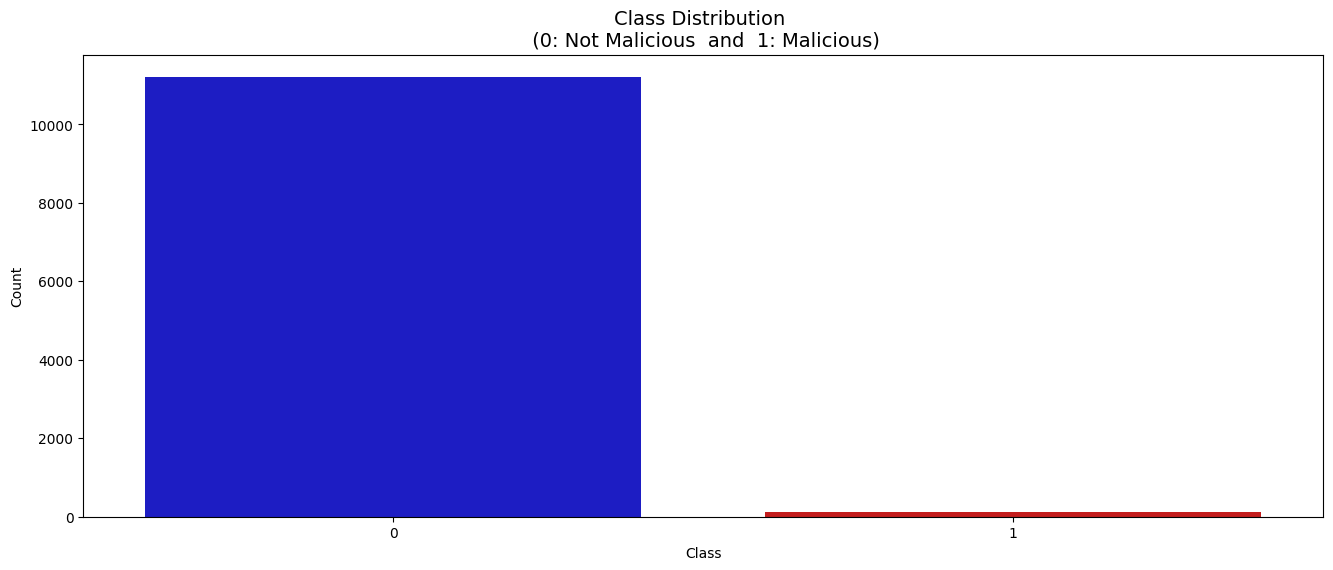

In [90]:
colors = ["#0101DF", "#DF0101"]

plt.figure(figsize=(16, 6))
ax = sns.countplot(normalised_data, x='out_and_tx_malicious', palette=colors)
plt.title('Class Distribution \n (0: Not Malicious  and  1: Malicious)', fontsize=14)
ax.set(xlabel='Class', ylabel='Count')
plt.show()

In [91]:
normalised_data.out_and_tx_malicious.value_counts()


0    11217
1      108
Name: out_and_tx_malicious, dtype: int64

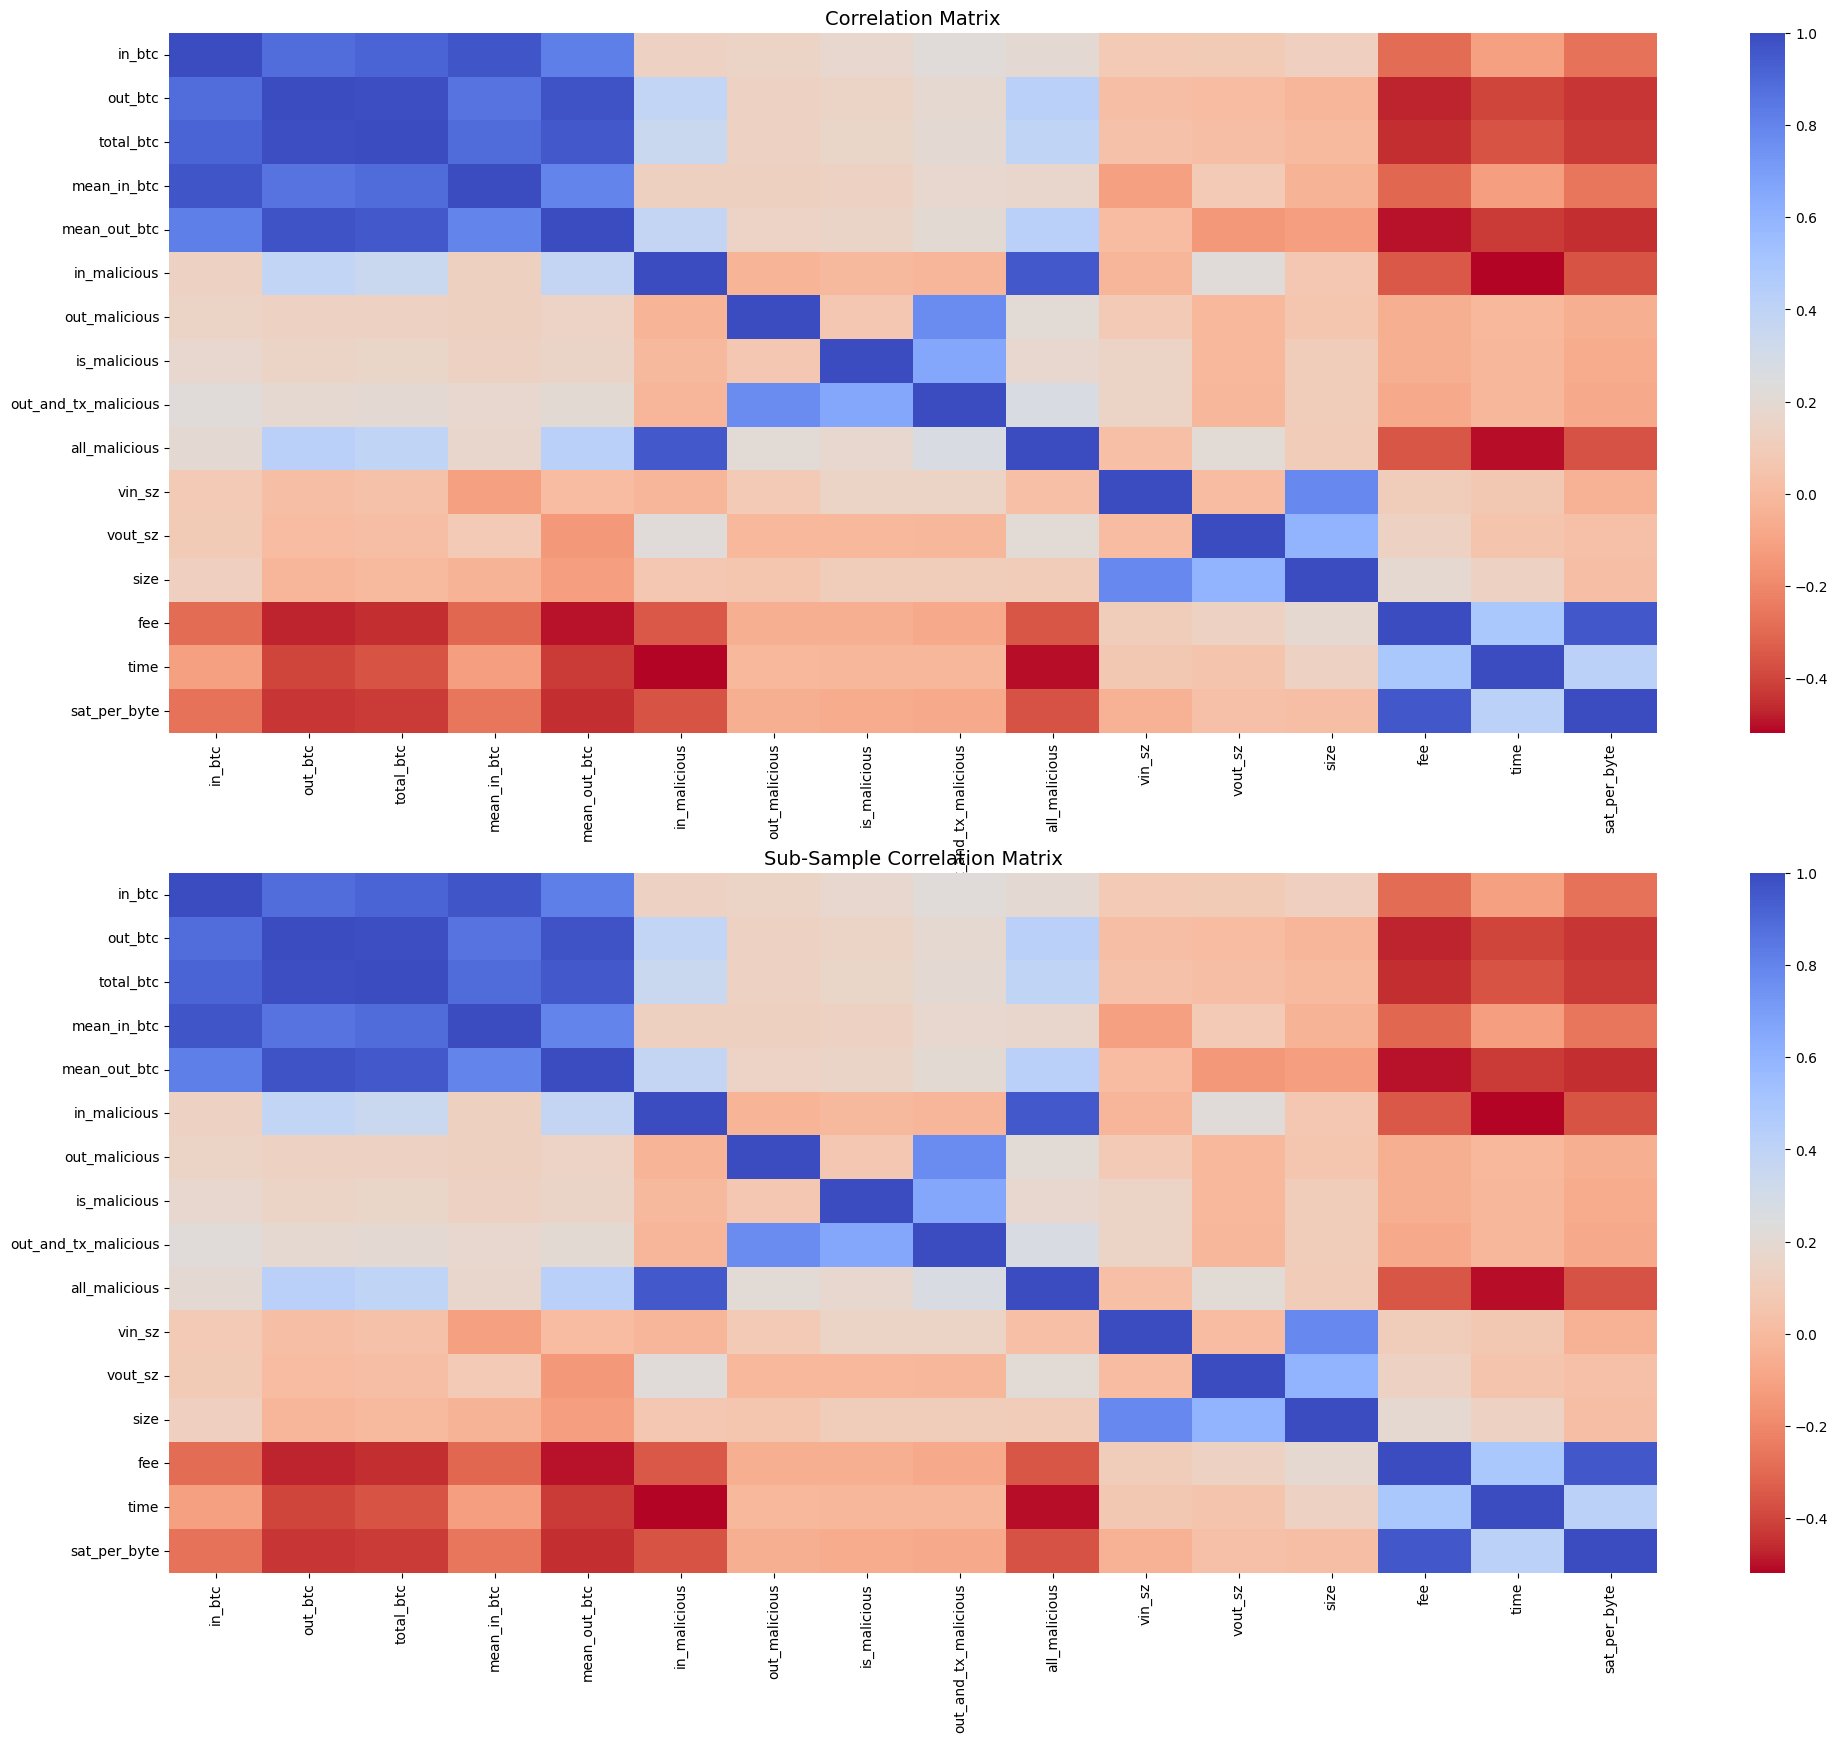

In [92]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24,20))

# Entire DataFrame
corr = normalised_data.iloc[:].corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1)
ax1.set_title("Correlation Matrix", fontsize=14)


sub_sample_corr = normalised_data.iloc[:].corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax2)
ax2.set_title('Sub-Sample Correlation Matrix', fontsize=14)
plt.show()

Negative Correlations: vin_sz, vout_sz negatively correlated. Notice how the lower these values are, the more likely the end result will be a fraud transaction.

Positive Correlations: in_btc, mean_in_btc, out_btc, mean_out_btc and total_btc are positively correlated. Notice how the higher these values are, the more likely the end result will be a fraud transaction.


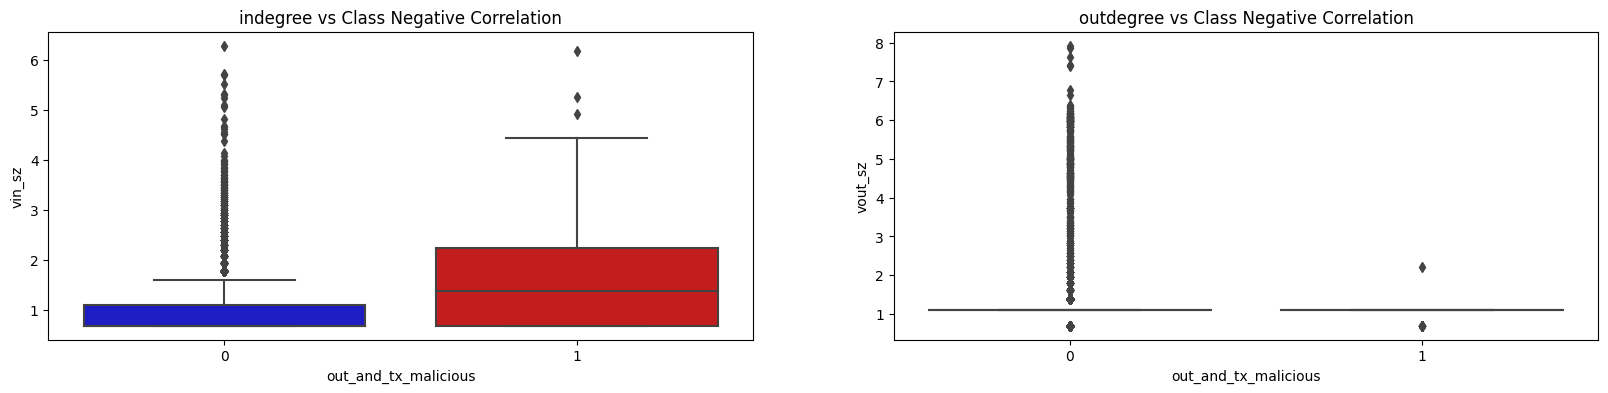

In [93]:
f, axes = plt.subplots(ncols=2, figsize=(20,4))

# Negative Correlations with our Class (The lower our feature value the more likely it will be a fraud transaction)
sns.boxplot(x="out_and_tx_malicious", y="vin_sz", data=normalised_data, palette=colors, ax=axes[0])
axes[0].set_title('indegree vs Class Negative Correlation')

sns.boxplot(x="out_and_tx_malicious", y="vout_sz", data=normalised_data, palette=colors, ax=axes[1])
axes[1].set_title('outdegree vs Class Negative Correlation')

plt.show()

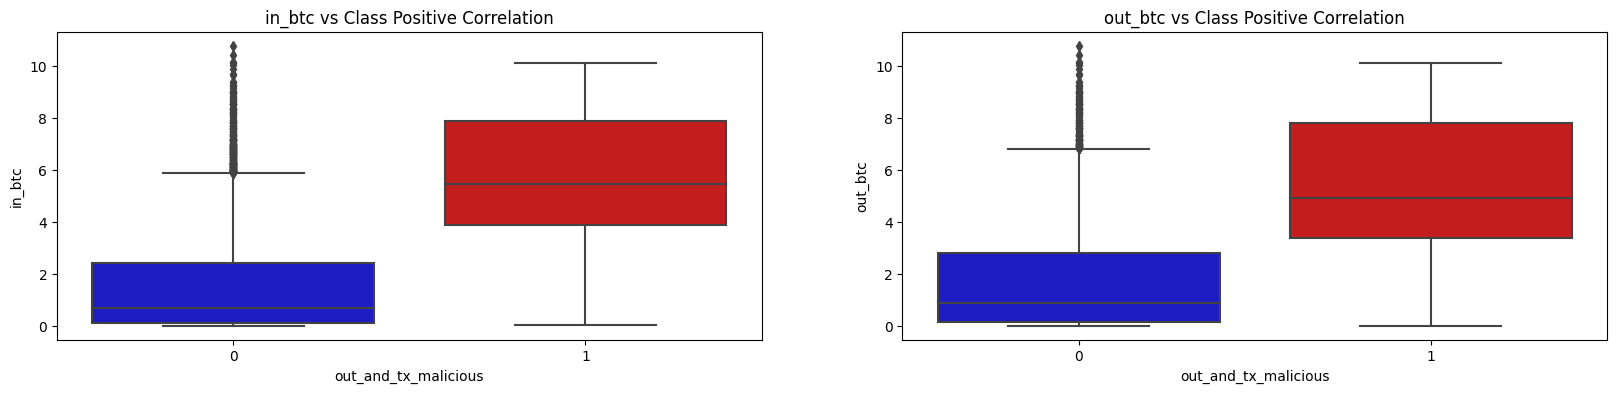

In [94]:
f, axes = plt.subplots(ncols=2, figsize=(20,4))

# Positive correlations (The higher the feature the probability increases that it will be a fraud transaction)
sns.boxplot(x="out_and_tx_malicious", y="in_btc", data=normalised_data, palette=colors, ax=axes[0])
axes[0].set_title('in_btc vs Class Positive Correlation')

sns.boxplot(x="out_and_tx_malicious", y="out_btc", data=normalised_data, palette=colors, ax=axes[1])
axes[1].set_title('out_btc vs Class Positive Correlation')

plt.show()


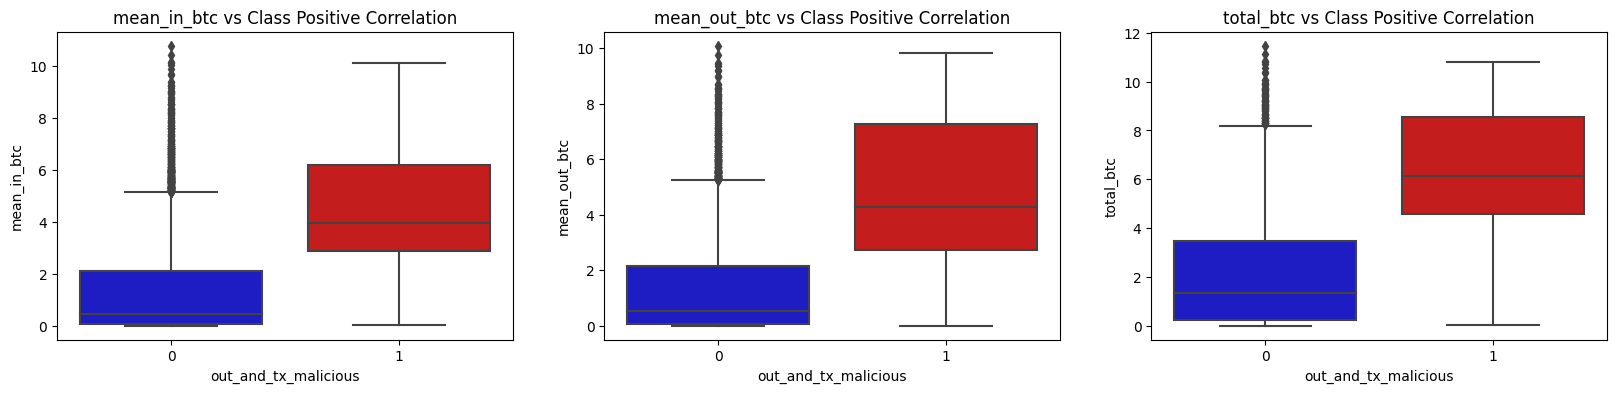

In [95]:
f, axes = plt.subplots(ncols=3, figsize=(20,4))

# Positive correlations (The higher the feature the probability increases that it will be a fraud transaction)

sns.boxplot(x="out_and_tx_malicious", y="mean_in_btc", data=normalised_data, palette=colors, ax=axes[0])
axes[0].set_title('mean_in_btc vs Class Positive Correlation')

sns.boxplot(x="out_and_tx_malicious", y="mean_out_btc", data=normalised_data, palette=colors, ax=axes[1])
axes[1].set_title('mean_out_btc vs Class Positive Correlation')

sns.boxplot(x="out_and_tx_malicious", y="total_btc", data=normalised_data, palette=colors, ax=axes[2])
axes[2].set_title('total_btc vs Class Positive Correlation')

plt.show()

Text(0.5, 1.0, 'sat per byte vs Class Positive Correlation')

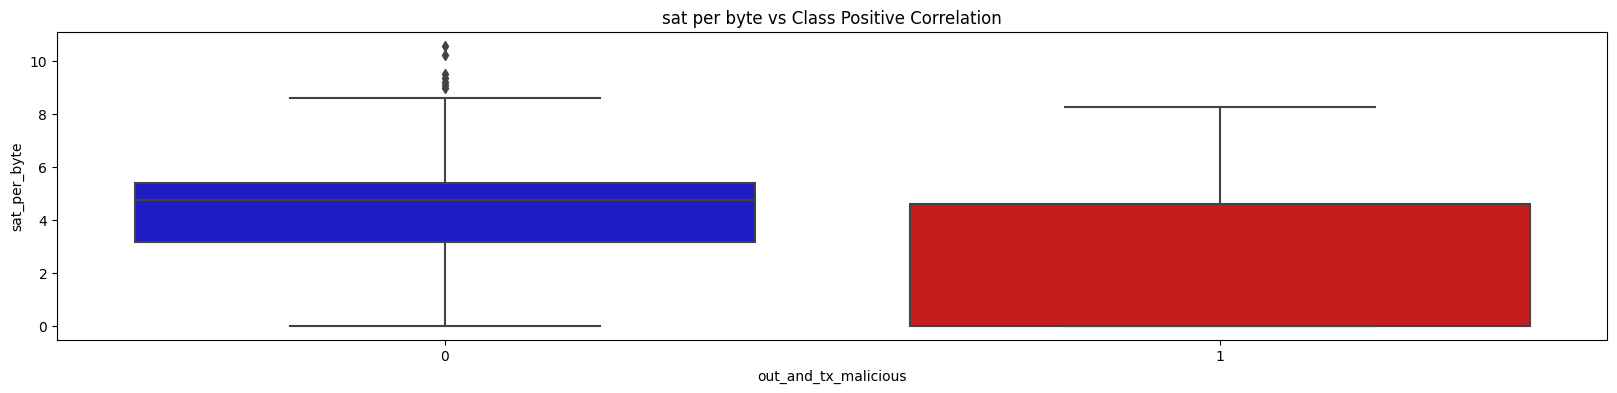

In [96]:
f, axes = plt.subplots(ncols=1, figsize=(20,4))

# Positive correlations (The higher the feature the probability increases that it will be a fraud transaction)
sns.boxplot(x="out_and_tx_malicious", y="sat_per_byte", data=normalised_data, palette=colors, ax=axes)
axes.set_title('sat per byte vs Class Positive Correlation')


Text(0.5, 1.0, 'size in bytes vs Class Positive Correlation')

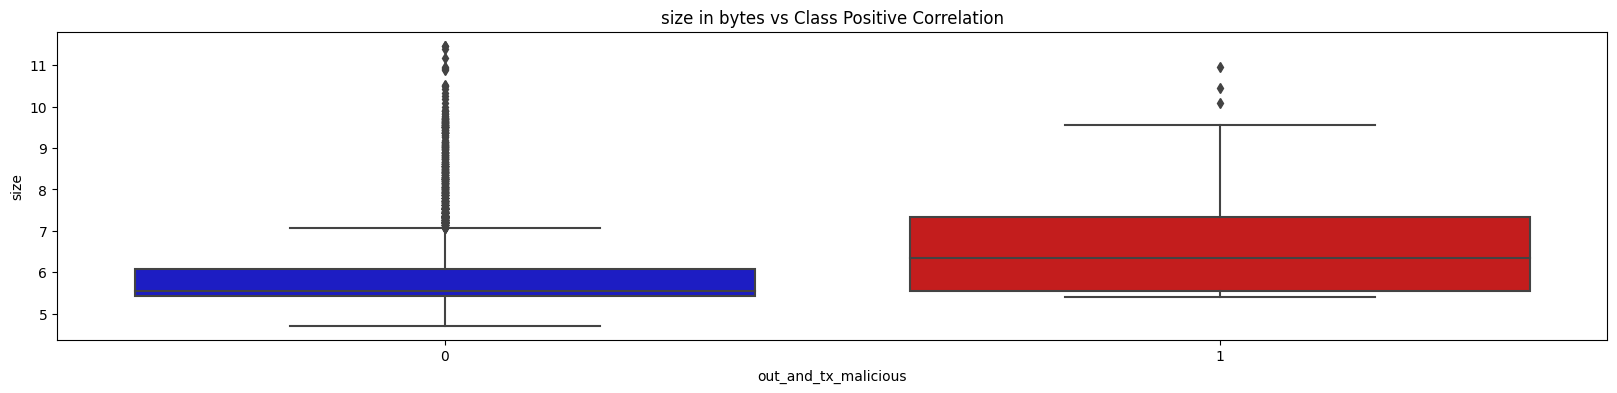

In [97]:
f, axes = plt.subplots(ncols=1, figsize=(20,4))

# Positive correlations (The higher the feature the probability increases that it will be a fraud transaction)
sns.boxplot(x="out_and_tx_malicious", y="size", data=normalised_data, palette=colors, ax=axes)
axes.set_title('size in bytes vs Class Positive Correlation')


In [108]:
# Save to file
normalised_data.to_csv('/content/drive/MyDrive/final year/ml/data/normalised_experimental_dataset.csv', index=False)